In [1]:
import pandas as pd
import numpy as np
from station import Station
import seaborn as sns
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload
import geopy.distance
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon

In [2]:
# read in data files
ride_df = pd.read_csv('data/CTA_-_Ridership_-__L__Station_Entries_-_Daily_Totals.csv')
map_df = pd.read_csv('data/CTA_-_System_Information_-_List_of__L__Stops.csv')
station_map_names = {'Lake':'Lake/State', 'Jackson':'Jackson/State',
                     'Washington':'Washington/Dearborn','Addison':'Addison-North Main'}
map_df.replace({"STATION_NAME": station_map_names}, inplace=True)

In [3]:
station_list = ride_df.stationname.unique().tolist()
sumlist = []
for station in station_list:
    stat = Station(station, ride_df, map_df)
    sumlist.append(stat.summary)
station_summary = pd.DataFrame(sumlist)    
station_summary.to_csv('data/station_summary.csv')

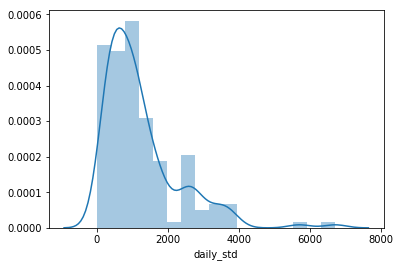

In [4]:
sns.distplot(station_summary['daily_std'])

In [15]:
high_stds = station_summary.sort_values(by='daily_std', ascending=False).iloc[0:9]
high_stations = high_stds.station.tolist()
high_stds.set_index('station', inplace=True)

In [82]:
high_stds

,5_yr_num_diff,5_yr_pct_diff,Sat_mean,Sat_std,Sun/Hol_mean,Sun/Hol_std,Weekday_mean,Weekday_std,daily_mean,daily_std,latitude,longitude,num_na,num_yrs_from_past_5
station,,,,,,,,,,,,,,
Clark/Lake,328.064384,0.021431,5112.702970,1882.363586,3906.938976,1620.315830,17965.562822,2868.452479,13901.899061,6714.698839,41.885737,-87.630886,0,5
Lake/State,587.442466,0.037362,9571.792079,4048.143372,6495.524606,3079.711894,16201.980739,4412.254604,13715.501721,5700.114941,41.884809,-87.627813,0,5
Jackson/State,-172.326712,-0.018835,4637.107811,1676.940372,3270.569882,1944.973115,11034.135274,1996.195230,8889.740845,3820.036582,41.878183,-87.629296,0,5
Washington/State,NaN,NaN,2842.545238,2136.088634,1700.389362,1361.260569,5975.798352,3890.640503,4849.686421,3814.963167,41.883100,-87.628700,0,0
Addison-North Main,41.748630,0.006135,7619.935094,4394.887829,5958.964567,4014.788301,7601.236058,3333.569089,7342.777465,3665.011920,41.947380,-87.719060,0,5
95th/Dan Ryan,743.466121,0.143039,7363.202210,1368.760161,5505.200000,1109.301992,12508.819123,2479.628887,10664.410535,3593.754973,41.722377,-87.624342,90,5
Washington/Wabash,NaN,NaN,3396.346154,1603.318261,8916.081197,3035.752612,5029.937500,2173.264555,7498.233533,3525.173041,41.883220,-87.626189,0,1
Washington/Dearborn,511.546575,0.054365,4181.415842,1760.111601,2793.965551,1438.873526,9684.427548,1987.502040,7806.032081,3443.689554,41.883164,-87.629440,0,5
Fullerton,-331.433562,-0.028854,7938.625963,2069.989985,5639.638780,1808.081373,11795.118253,2600.911912,10267.807042,3415.141617,41.925051,-87.652866,0,5


In [17]:
# create geodataframe from stations with highest STDs
geometry = [Point(x,y) for x,y in zip(high_stds['longitude'], high_stds['latitude'])]
crs = {'init':'epsg:4326'}
geo_df = gpd.GeoDataFrame(index=high_stds.index, crs=crs, geometry=geometry)

In [18]:
neigh_map = gpd.read_file(
    'data/Boundaries - Community Areas/geo_export_c539fca7-2c77-4148-be09-2c656a4bc388.shp')
# get representative coordinates from each neighborhood
neigh_map['coords'] = neigh_map['geometry'].apply(
    lambda x: x.representative_point().coords[:])
neigh_map['coords'] = [coords[0] for coords in neigh_map['coords']]
neigh_map.set_index('community', inplace=True)

In [27]:
# check which neighborhood each station falls in
station_to_neigh = geo_df.assign(**{key: geo_df.within(geom) for key,
                                    geom in neigh_map['geometry'].items()})
station_to_neigh = station_to_neigh.loc[:, (station_to_neigh != 0).any(axis=0)]

In [36]:
ncols = ['IRVING PARK', 'LOOP', 'ROSELAND', 'LINCOLN PARK']
station_to_neigh['neighborhood'] = station_to_neigh[ncols].idxmax(axis=1)
station_to_neigh.drop(columns=ncols, inplace=True)

In [65]:
for item in station_to_neigh['neighborhood']:
    inds = station_to_neigh.index[station_to_neigh['neighborhood']==item].tolist()
    station_to_neigh.loc[inds,'polygon'] = neigh_map.loc[item, 'geometry']
    station_to_neigh.loc[inds,'shape_area'] = neigh_map.loc[item, 'shape_area']
    station_to_neigh.loc[inds,'shape_len'] = neigh_map.loc[item, 'shape_len']

In [72]:
neigh_to_station = station_to_neigh.copy()
neigh_to_station.rename(columns={'polygon':'geometry', 'geometry':'points'}, inplace=True)

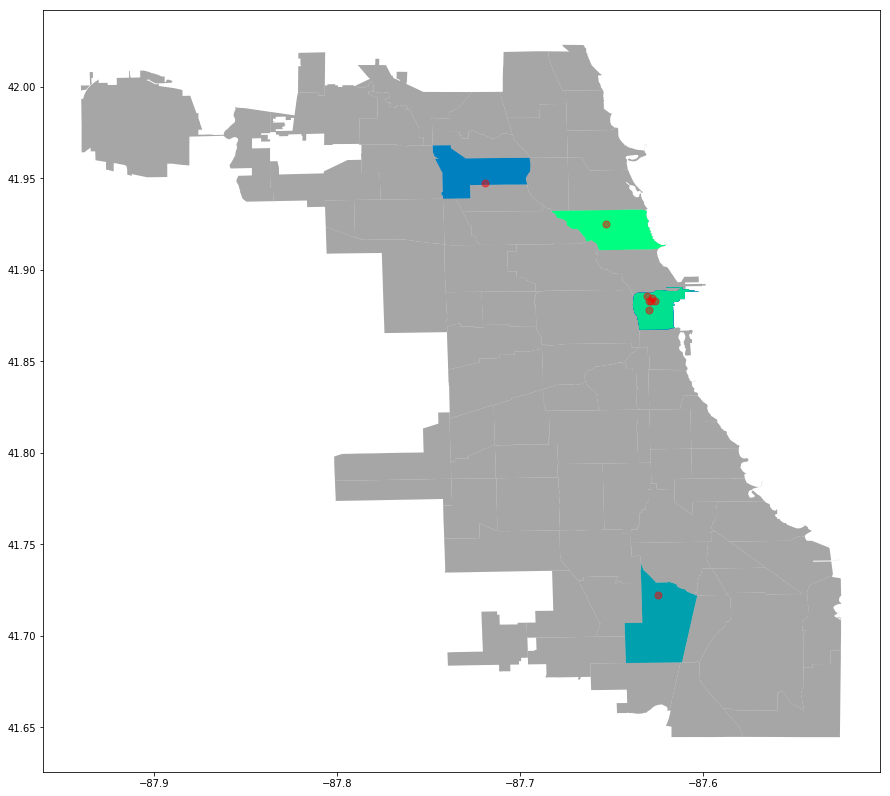

In [81]:
fig, ax = plt.subplots(figsize=(15,15))
neigh_map.plot(ax=ax,alpha=.7, color='grey')
neigh_to_station.plot(ax=ax,cmap='winter')
station_to_neigh.plot(ax=ax, color='red', marker='o', alpha=.5, markersize=50)

In [78]:
# fig, ax = plt.subplots(figsize=(15,15))
# neigh_map.plot(ax=ax,alpha=.7, cmap='Greys')
# plt.annotate(s='LOOP', xy=neigh_map.loc['LOOP','coords'],
#                  horizontalalignment='center')

# geo_df.plot(ax=ax, markersize=100, color='red', marker='o', alpha=.3)